# Tutorial 2: MOSTA

## Environment Configuration & Package Loading

In [1]:
import os
import torch
import scanpy as sc
from GenOT import genot

C:\ProgramData\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.4.1'
os.environ['PATH'] = 'C:/Program Files/R/R-4.4.1/bin/x64;' + os.environ['PATH']

## Data Loading

In [3]:
adata = sc.read_h5ad(r'..\Data\E10.5_E1S1.MOSTA.h5ad')
adata = sc.pp.subsample(adata, n_obs=5000, random_state=0, copy=True)

## Data Preprocessing

In [4]:
from GenOT.utils import get_unique_marker_genes

unique_marker_genes = get_unique_marker_genes(adata, annotation_column_name='annotation', n_top_genes=50)
adata = adata[:, unique_marker_genes].copy()

Using annotation column 'annotation' for marker gene analysis...
Unique values in annotation column: ['Cavity', 'Blood vessel', 'Spinal cord', 'Surface ectoderm', 'Sclerotome', 'Lung primordium', 'Heart', 'Head mesenchyme', 'Brain', 'Connective tissue', 'Liver', 'Branchial arch', 'Urogenital ridge']
Extracted 453 unique marker genes from the top 50 genes per annotation group.
First 10 extracted marker genes: ['1110004E09Rik', '1110008F13Rik', '2010111I01Rik', 'Abracl', 'Acp1', 'Acp5', 'Acta1', 'Acta2', 'Actc1', 'Adcy9']...


In [5]:
adata

AnnData object with n_obs × n_vars = 5000 × 453
    obs: 'annotation', 'leiden', 'Region', 'ground_truth'
    var: 'n_cells'
    uns: 'annotation_colors', 'leiden', 'leiden_colors', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'rank_genes_annotation'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

## Run GenOT

In [6]:
encoder = genot.Encoder(adata, epochs=700, pca_n=16, device=device, )

In [7]:
adata = encoder.train_encoder()

Begin to train ...


100%|██████████| 700/700 [00:12<00:00, 57.92it/s]

 finished!


## Spatial Domain Identification (leiden)

In [8]:
from GenOT.utils import clustering

n_clusters = len(adata.obs["annotation"].cat.categories)
clustering(adata, n_clusters=n_clusters + 1, method='leiden', refinement=False, search=False)

## Clustering Quality Evaluation(leiden)

In [9]:
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score
)

true_labels = adata.obs['annotation']
pred_labels = adata.obs['domain']

# ARI (Adjusted Rand Index)
ari = adjusted_rand_score(true_labels, pred_labels)
# NMI (Normalized Mutual Information)
nmi = normalized_mutual_info_score(true_labels, pred_labels)
# Homogeneity (HOM)
hom = homogeneity_score(true_labels, pred_labels)
# Completeness (COM)
com = completeness_score(true_labels, pred_labels)

print(f'ARI: {ari:.4f}')
print(f'NMI: {nmi:.4f}')
print(f'HOM: {hom:.4f}')
print(f'COM: {com:.4f}')

ARI: 0.4353
NMI: 0.5694
HOM: 0.5712
COM: 0.5676


## Visualization

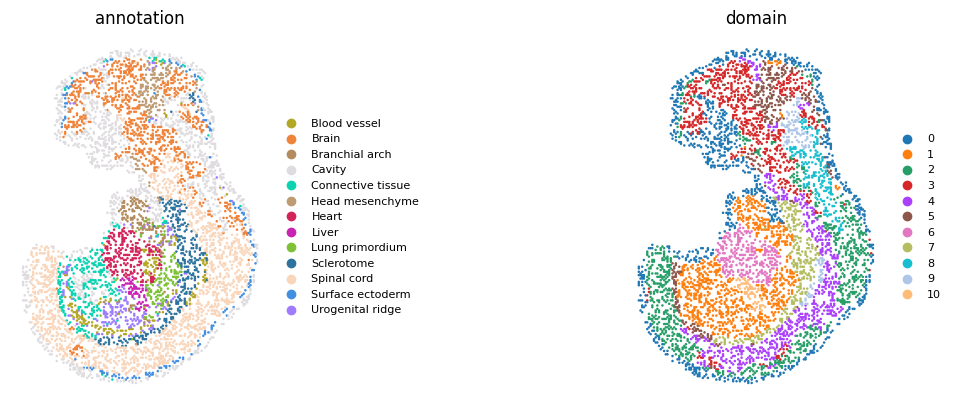

In [10]:
sc.pl.spatial(
    adata,
    color=['annotation', 'domain'],
    title=['annotation', 'domain'],
    legend_fontsize=8,
    ncols=2,
    frameon=False,
    size=1.5,
    spot_size=1
)